We will be using the [Daily Minimum Temperatures in Melbourne](https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs we will also use Convolutional layers to improve the model's performance.

In [11]:
#Import libraries
import csv
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [29]:
TEMPERATURES_CSV = 'daily-minimum-temperatures-in-me.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Daily minimum temperatures in Melbourne, Australia, 1981-1990"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As we can see, each data point is composed of the date and the recorded minimum temperature for that date. We will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [14]:
# Read the data from the csv file:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        count = 0
        for row in reader:
            if len(row) == 2: # avoid footer rows
                temp = row[1]
                temp_cleaned = temp.replace('?','') # replacing "?" since it prevents function from ...
                temp_float = float(temp_cleaned) # ... converting into float
                temperatures.append(temp_float)
                times.append(int(count))
                count += 1
            
    return times, temperatures


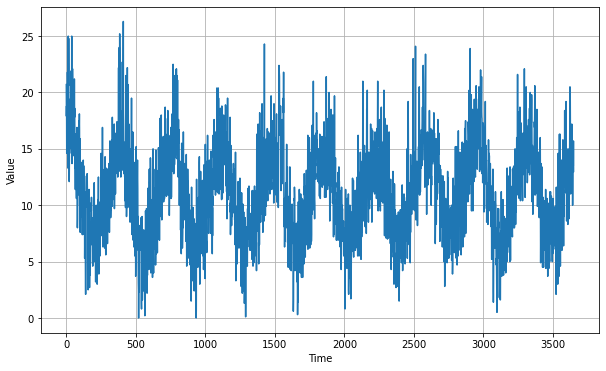

In [15]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = 'daily-minimum-temperatures-in-me.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [16]:
print(G.SERIES)

[20.7 17.9 18.8 ... 13.5 15.7 13. ]


## Split the Dataset

In [17]:
# Define the split time
split_time = G.SPLIT_TIME

# Get the train set 
time_train = G.TIME[:split_time]
x_train = G.SERIES[:split_time]

# Get the validation set
time_valid = G.TIME[split_time:]
x_valid = G.SERIES[split_time:]

## Prepare Features and Labels

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
                 lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
# Parameters
window_size = G.WINDOW_SIZE
batch_size = G.BATCH_SIZE
shuffle_buffer_size = G.SHUFFLE_BUFFER_SIZE

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [20]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 dense (Dense)               (None, None, 28)          3612      
                                                                 
 dense_1 (Dense)             (None, None, 10)          290       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 4,425
Trainable params: 4,425
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [21]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100


c:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 168ms/step - loss: 84.4372
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 49.0350
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 33.2720
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 24.9018
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 20.6278
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 18.5659
Epoch 7/100
10/10 [==============================] - 1s 34ms/step - loss: 17.6433
Epoch 8/100
10/10 [==============================] - 0s 31ms/step - loss: 17.2434
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 17.0655
Epoch 10/100
10/10 [==============================] - 0s 29ms/step - loss: 16.9799
Epoch 11/100
10/10 [==============================] - 0s 29ms/step - loss: 16.9335
Epoch 12/100
10/10 [==============================] - 0s 34ms/step - loss: 16.9005
Epoch 13/100
10/10 [====

## Model Prediction

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
forecast = model_forecast(model, G.SERIES[..., np.newaxis], window_size)

results = forecast[split_time - window_size:-1, -1, 0]

113/113 [==============================] - 1s 5ms/step


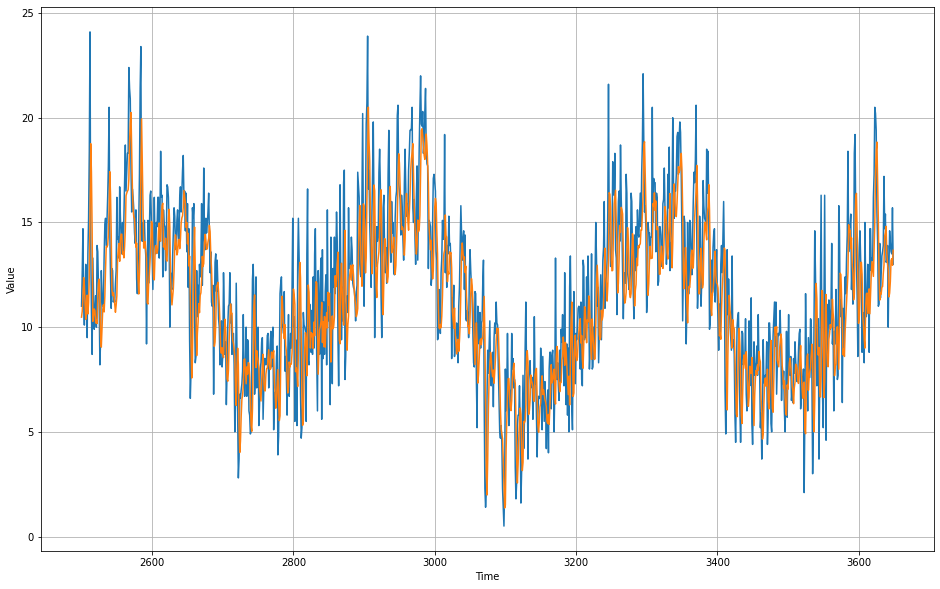

In [24]:
plt.figure(figsize=(16, 10))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

2.0905316
